# Mixture Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
import scipy

In [2]:
data = pd.read_csv("../data/temperature/monthly_csv.csv", sep=",")

In [3]:
data.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [4]:
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
gcag_data = pd.DataFrame(data[data['Source'] == 'GCAG'])
gcag_data.shape

(1644, 3)

In [6]:
gcag_data['ts'] = pd.to_datetime(gcag_data['Date']).astype(np.int64)

In [7]:
np_array = gcag_data[['ts', 'Mean']].values

In [8]:
gcag_data.head()

,Source,Date,Mean,ts
0,GCAG,2016-12-06,0.7895,1480982400000000000
2,GCAG,2016-11-06,0.7504,1478390400000000000
4,GCAG,2016-10-06,0.7292,1475712000000000000
6,GCAG,2016-09-06,0.8767,1473120000000000000
8,GCAG,2016-08-06,0.8998,1470441600000000000


In [9]:
np_array[:,0] = (np_array[:,0] / 1000000.0)

In [10]:
mixture = GaussianMixture(n_components=2, covariance_type='full').fit(np_array)

In [11]:
mixture.means_

array([[-1.44245218e+12, -1.26257115e-01],
       [ 6.59003938e+11,  3.55864018e-01]])

In [12]:
gcag_data['mixture'] = mixture.predict(np_array)

In [13]:
gcag_data.head()

,Source,Date,Mean,ts,mixture
0,GCAG,2016-12-06,0.7895,1480982400000000000,1
2,GCAG,2016-11-06,0.7504,1478390400000000000,1
4,GCAG,2016-10-06,0.7292,1475712000000000000,1
6,GCAG,2016-09-06,0.8767,1473120000000000000,1
8,GCAG,2016-08-06,0.8998,1470441600000000000,1


In [14]:
gcag_data['mean1'] = gcag_data['Mean'] * gcag_data['mixture'] 
gcag_data['mean0'] = gcag_data['Mean'] * (1-gcag_data['mixture'] )

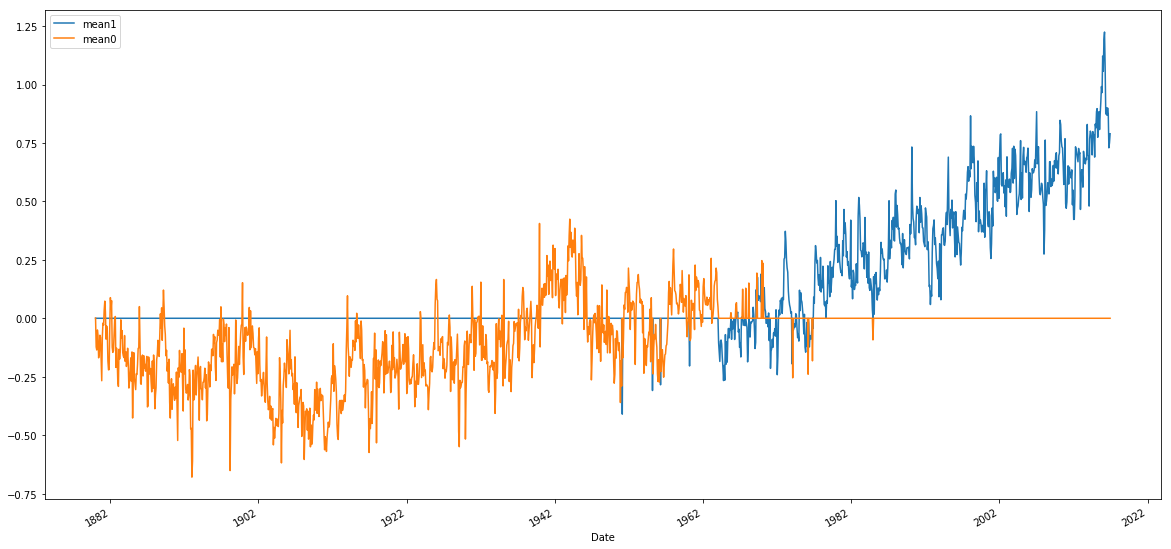

In [15]:
gcag_data[['Date', 'mean1', 'mean0']].set_index('Date').plot(figsize=(20,10));

In [16]:
gcag_data[gcag_data['mixture'] == 1.0].max()

Source                    GCAG
Date       2016-12-06 00:00:00
Mean                    1.2245
ts         1480982400000000000
mixture                      1
mean1                   1.2245
mean0                        0
dtype: object

In [17]:
gcag_data[gcag_data['mixture'] == 1.0].min()

Source                    GCAG
Date       1951-02-06 00:00:00
Mean                   -0.4101
ts         -596505600000000000
mixture                      1
mean1                  -0.4101
mean0                        0
dtype: object

In [18]:
mixture.means_

array([[-1.44245218e+12, -1.26257115e-01],
       [ 6.59003938e+11,  3.55864018e-01]])

In [19]:
mixture.covariances_

array([[[6.95849920e+23, 8.49559175e+10],
        [8.49559175e+10, 3.50777195e-02]],

       [[2.56538835e+23, 1.32839482e+11],
        [1.32839482e+11, 8.33602094e-02]]])

In [20]:
mixture.weights_

array([0.63690764, 0.36309236])

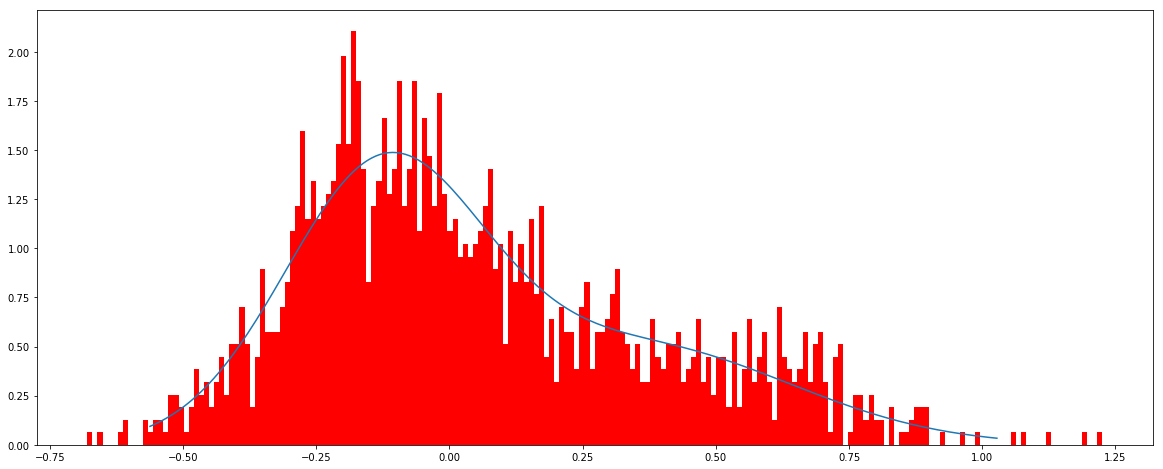

In [21]:
date_desc_pre = gcag_data[gcag_data.Date < '1948-07-06'].describe()
date_desc_post = gcag_data[gcag_data.Date >= '1948-07-06'].describe()

loc_pre = mixture.means_[0][1]
scale_pre = np.sqrt(mixture.covariances_[0][1][1])

loc_post = mixture.means_[1][1]
scale_post = np.sqrt(mixture.covariances_[1][1][1])

lower = scipy.stats.norm.ppf(0.01,loc_pre,scale_pre)
upper = scipy.stats.norm.ppf(0.99,loc_post,scale_post)
x_comp = scipy.linspace(lower,upper,200)


alpha = 200/np.abs(gcag_data['Mean']).sum()

y_1 = scipy.stats.norm.pdf(x_comp,loc_pre,scale_pre) 
y_2 = scipy.stats.norm.pdf(x_comp,loc_post,scale_post)

y_comp = (mixture.weights_[0] * y_1 + mixture.weights_[1] * y_2)

plt.figure(1, figsize=(20, 8))

plt.hist(gcag_data['Mean'], bins=200, density=True, color='red')
plt.plot(x_comp, y_comp)

plt.show()

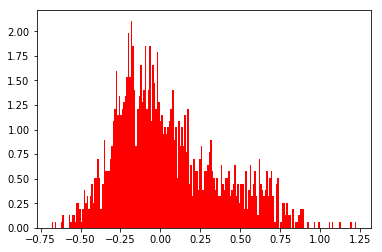

In [22]:
hist_data = plt.hist(gcag_data['Mean'], bins=200, density=True, color='red')

In [23]:
hist_scaled = hist_data[0] / hist_data[0].sum()

In [24]:
calc_1 = mixture.weights_[0] * scipy.stats.norm.pdf(hist_data[1],loc_pre,scale_pre) 
calc_2 = mixture.weights_[1] * scipy.stats.norm.pdf(hist_data[1],loc_post,scale_post)

In [25]:
calc_comb = calc_1 + calc_2
calc_comb = calc_comb/calc_comb.sum()

In [26]:
((calc_comb[0:200] - hist_scaled)*(calc_comb[0:200] - hist_scaled)).sum()

0.0006002627453811256